In [1]:
!pip install transformers pandas openpyxl scikit-learn matplotlib seaborn

In [2]:
from google.colab import files
uploaded = files.upload()

Saving break_freeze_for_polysemy profiling.xlsx to break_freeze_for_polysemy profiling.xlsx


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

# 엑셀 파일 로드
filename = [f for f in uploaded if f.endswith(".xlsx")][0]
df = pd.read_excel(filename)

sentences = df.iloc[:, 2]  # C열: 문장
syntaxes = df.iloc[:, 3]   # D열: 구문
labels = df.iloc[:, 5]     # F열: 의미

keywords = ['break', 'broke', 'broken', 'breaking', 'freeze', 'froze', 'frozen', 'freezing']

def extract_token_embedding(sentence, keywords):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    match_indices = [i for i, t in enumerate(tokens) if any(kw in t for kw in keywords)]
    if not match_indices:
        return [None] * 768
    return outputs.last_hidden_state[0][match_indices[0]].numpy().tolist()

embeddings, valid_labels, valid_syntaxes, valid_sentences = [], [], [], []

for sent, syn, label in tqdm(zip(sentences, syntaxes, labels), total=len(sentences)):
    vec = extract_token_embedding(str(sent), keywords)
    if vec[0] is not None:
        embeddings.append(vec)
        valid_labels.append(label)
        valid_syntaxes.append(syn)
        valid_sentences.append(sent)

# 저장
embedding_df = pd.DataFrame(embeddings)
embedding_df['sense'] = valid_labels
embedding_df['syntax'] = valid_syntaxes
embedding_df['sentence'] = valid_sentences
embedding_df.to_csv("bert_embeddings_with_syntax.csv", index=False)

from google.colab import files
files.download("bert_embeddings_with_syntax.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  0%|          | 0/1060 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 1060/1060 [03:11<00:00,  5.55it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving bert_embeddings_with_syntax.csv to bert_embeddings_with_syntax (1).csv


In [6]:
# 📄 데이터 로드 (sense + syntax + sentence 포함된 CSV)
filename = list(uploaded.keys())[0]
# Try reading with 'utf-8' encoding first
try:
    df = pd.read_csv(filename, encoding='utf-8')
except UnicodeDecodeError:
    # If 'utf-8' fails, try 'cp949' or 'latin-1'
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin-1')
# Specify 'euc-kr' encoding

In [7]:
# 🧠 전처리: 동사 태깅 (break vs freeze)
df["verb"] = df["sense"].apply(lambda x: "break" if "break" in str(x).lower() else (
                                          "freeze" if "freeze" in str(x).lower() else "unknown"))

In [8]:
### 추가 (verb - sense 수동 mapping) ###

# Step 1: sense-to-verb 딕셔너리 정의
sense_to_verb = {
    # break senses
    'destruction': 'break',
    'bodily harm': 'break',
    'EPS breakdown': 'break',
    'decoding': 'break',
    'disclosure': 'break',
    'emergence': 'break',
    'violation': 'break',
    'breakthrough': 'break',
    'interruption': 'break',
    'termination': 'break',
    'change': 'break',

    # freeze senses
    'physical freezing': 'freeze',
    'bodily freezing': 'freeze',
    'natural freezing': 'freeze',
    'preservation': 'freeze',
    'immobilization': 'freeze',
    'immobilization_mechanical': 'freeze',
    'immobilization_tech': 'freeze',
    'emotional/mental freezing': 'freeze',
    'economical freezing': 'freeze',
    'suspension': 'freeze',
}

# Step 2: verb 컬럼 생성
df['verb'] = df['sense'].map(sense_to_verb).fillna('unknown')

In [9]:
print(df)

             0         1         2         3         4         5         6  \
0    -0.268296  0.515550 -0.036981  0.167487  0.746249 -0.043274  0.287072   
1     0.279771  0.427525  0.143628  0.469398  0.902733 -0.045868 -0.058215   
2    -0.020743  0.409262  0.079372  1.068581  1.152671 -0.147916  0.561047   
3    -0.080311  0.102309 -0.114360  0.708209  0.477703 -0.529139  0.313383   
4    -0.194344  0.342621  0.341211  0.876533  0.969503 -0.255095  0.202830   
...        ...       ...       ...       ...       ...       ...       ...   
1055  0.759600  0.166569  0.288335  0.212422  1.088400  0.094660  0.476108   
1056  0.968606  0.882645 -0.076489 -0.195994 -0.038849 -0.172950  0.069940   
1057  1.087639  0.327397  0.624524  0.081621  0.547900  0.134391  0.449261   
1058  0.080907  0.769553 -0.106087  0.072690 -0.025398 -0.181115  0.234857   
1059  0.866261  0.411507 -1.147923  0.276137 -0.275189 -0.422593  0.360351   

             7         8         9  ...       762       763    

In [10]:
verbs_to_analyze = ["break", "freeze"]


🔍 Analyzing verb: break
PC1 range for 'Caus' syntax in 'break':
count    489.000000
mean       0.823822
std        2.729932
min       -6.639200
25%       -1.187297
50%        1.152205
75%        3.159493
max        5.783295
Name: PC1, dtype: float64
Explained Variance Ratio:
[0.08582415 0.05350876]


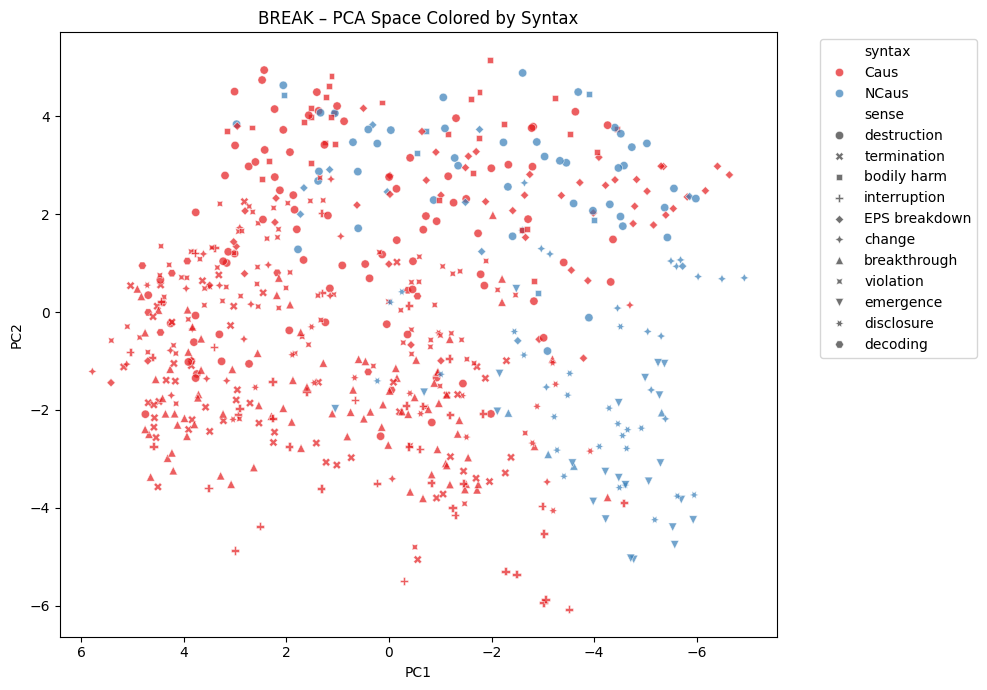

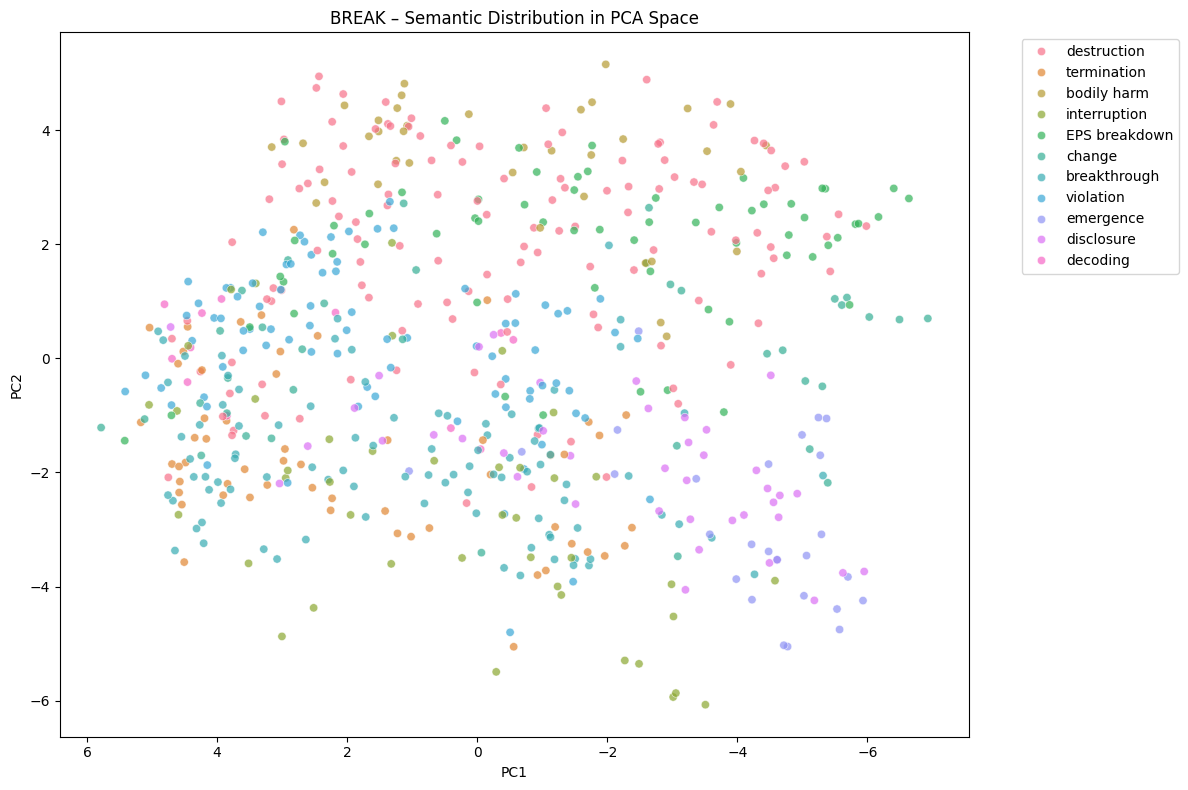


🔍 Analyzing verb: freeze
Explained Variance Ratio:
[0.19726374 0.06595865]


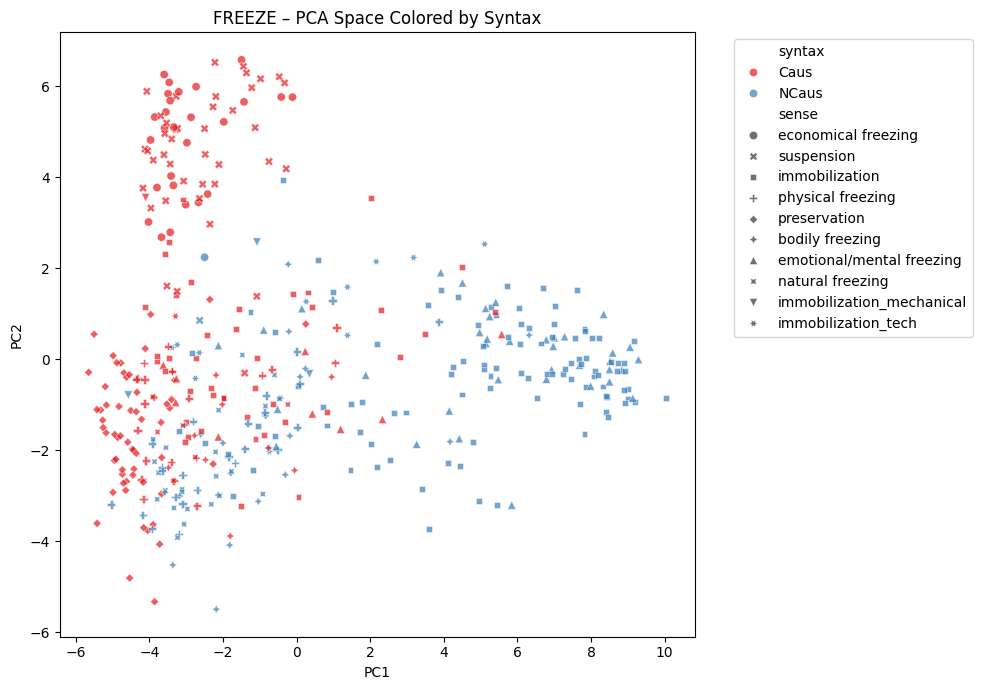

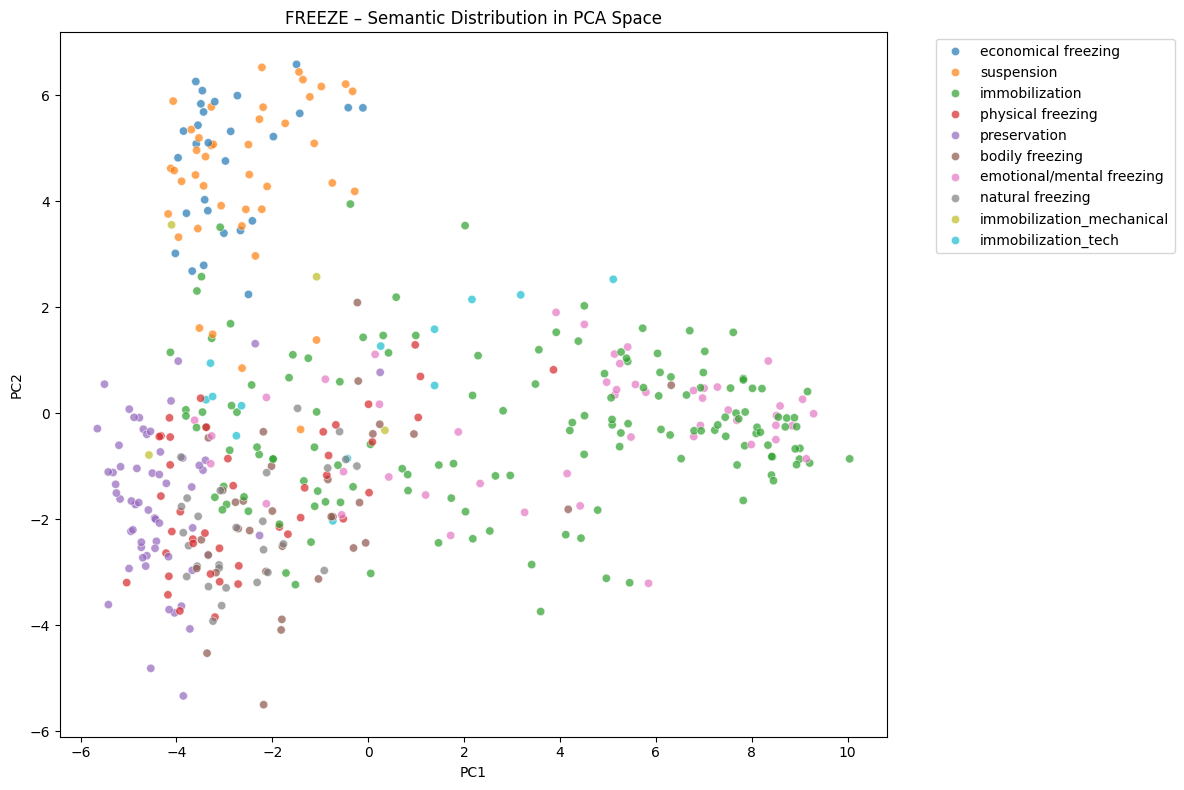

In [26]:
# 🔁 동사별 PCA 수행
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")
    sub_df = df[df['verb'] == verb].copy()

    # 임베딩만 추출
    X = sub_df.iloc[:, :768]

    # PCA 수행
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    sub_df["PC1"], sub_df["PC2"] = components[:, 0], components[:, 1]

    # "break" 동사의 경우 PC1 축을 뒤집음
    if verb == "break":
        sub_df["PC1"] = -sub_df["PC1"]
        # Print PC1 values for Caus syntax to debug
        print(f"PC1 range for 'Caus' syntax in '{verb}':")
        print(sub_df[sub_df['syntax'] == 'Caus']['PC1'].describe())


    # 설명력 출력
    print("Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)

    # 구문 분포 시각화
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=sub_df, x="PC1", y="PC2", hue="syntax", style="sense", palette="Set1", alpha=0.7)
    plt.title(f"{verb.upper()} – PCA Space Colored by Syntax")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Reverse x-axis for the 'break' syntax plot
    if verb == "break":
        plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.show()

    # 의미군 분포 시각화
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=sub_df, x="PC1", y="PC2", hue="sense", alpha=0.7)
    plt.title(f"{verb.upper()} – Semantic Distribution in PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Reverse x-axis for the 'break' semantic distribution plot
    if verb == "break":
        plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

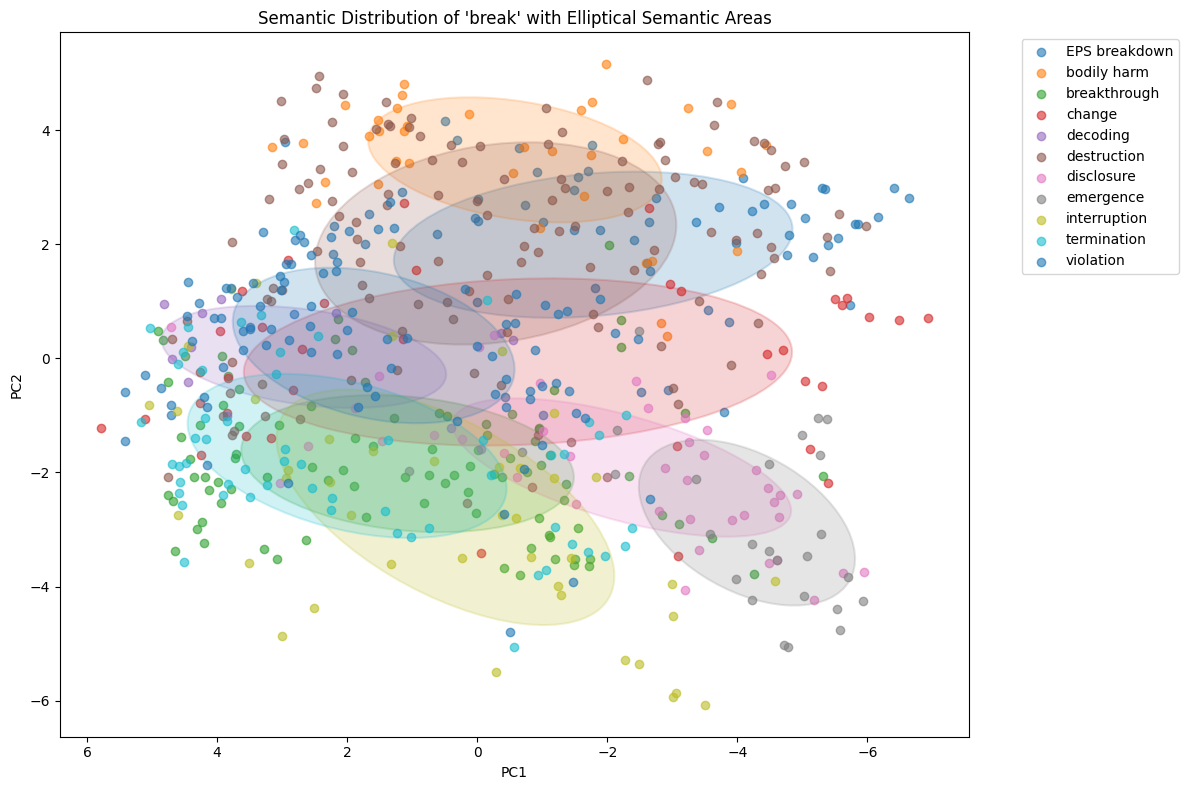

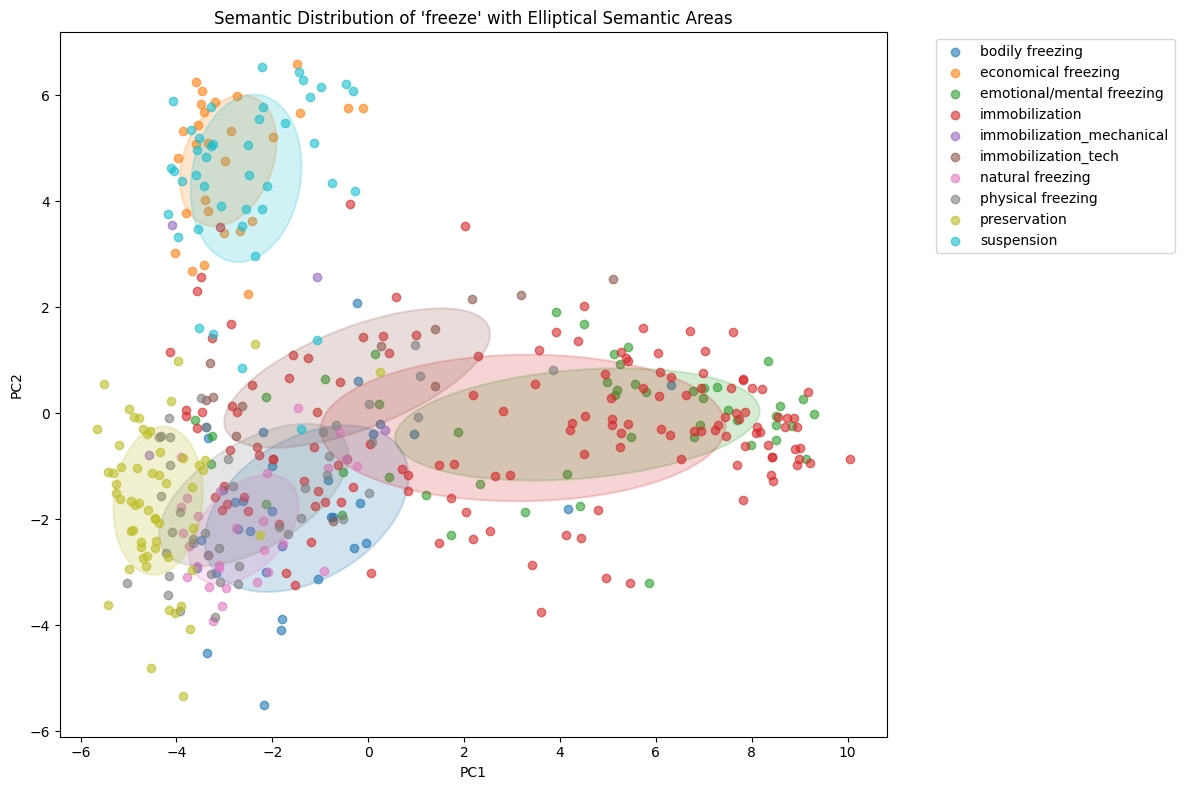

In [21]:
from matplotlib.patches import Ellipse

for verb in ["break", "freeze"]:
    sub_df = df[df["verb"] == verb].copy()

    # 임베딩만 추출
    X = sub_df.iloc[:, :768]

    # PCA 수행
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    sub_df["PC1"], sub_df["PC2"] = components[:, 0], components[:, 1]

    # "break" 동사의 경우 PC1 축을 뒤집음
    if verb == "break":
        sub_df["PC1"] = -sub_df["PC1"]

    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("tab10", n_colors=len(sub_df["sense"].unique()))

    for i, (sense, group) in enumerate(sub_df.groupby("sense")):
        x, y = group["PC1"], group["PC2"]
        color = palette[i % len(palette)]
        plt.scatter(x, y, alpha=0.6, label=sense, color=color)

        # 타원 (클러스터 확산 시각화)
        if len(x) >= 5:
            cov = np.cov(x, y)
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
            width, height = 2 * np.sqrt(vals)
            ellipse = Ellipse((x.mean(), y.mean()), width, height, angle=theta,
                              edgecolor=color, fc=color, lw=1.5, alpha=0.2)
            plt.gca().add_patch(ellipse)

    plt.title(f"Semantic Distribution of '{verb}' with Elliptical Semantic Areas")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()